In [1]:
# import packages
using LinearAlgebra
using Distributions
using PyPlot
using PGFPlotsX
using LaTeXStrings
using Contour

┌ Info: Precompiling Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1662
┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1662
┌ Info: Precompiling PGFPlotsX [8314cec4-20b6-5062-9cdb-752b83310925]
└ @ Base loading.jl:1662


In [2]:
# extend Base functionality for convenience
Base.precision(dist::Normal) = 1 / var(dist)

In [3]:
# specify SNR function
SNR(q::Normal) = abs(mean(q)) / std(q)

# specify SPR function
SPR(q::Normal) = abs(mean(q)) + std(q)

# specify BMR function
function BMR(p::Normal, p_new::Normal, q::Normal)
    σ2_new = 1 / (precision(q) + precision(p_new) - precision(p))
    μ_new = σ2_new * (precision(q)*mean(q) + precision(p_new)*mean(p_new) - precision(p)*mean(p))
    q_new = Normal(μ_new, sqrt(σ2_new))
    ΔF = log(abs(precision(p_new) * precision(q) * var(q_new) * var(p)))/2 - (abs2(mean(q))*precision(q) + abs2(mean(p_new))*precision(p_new) - abs2(mean(q_new))*precision(q_new) - abs2(mean(p))*precision(p) )/2
    return ΔF
end

BMR (generic function with 1 method)

In [4]:
# set initial conditions
p = Normal(0, 1)
p_new = Normal(0, sqrt(1e-16))

Normal{Float64}(μ=0.0, σ=1.0e-8)

In [5]:
# preallocate and specify ranges
SNR_map = Matrix(undef, 101, 101)
SPR_map = Matrix(undef, 101,101)
BMR_map = Matrix(undef, 101,101)
μ_range = -1.5:0.03:1.5
σ2_range = 0.01:0.015:1.51

0.01:0.015:1.51

In [6]:
# perform computations
for k1 in 1:length(μ_range)
    for k2 in 1:length(σ2_range)

        # specify original variational posterior
        q = Normal(μ_range[k1], sqrt((σ2_range[k2])))

        # compute metrics
        SNR_map[k1,k2] = SNR(q)
        SPR_map[k1,k2] = SPR(q)
        BMR_map[k1,k2] = BMR(p, p_new, q)

    end
end

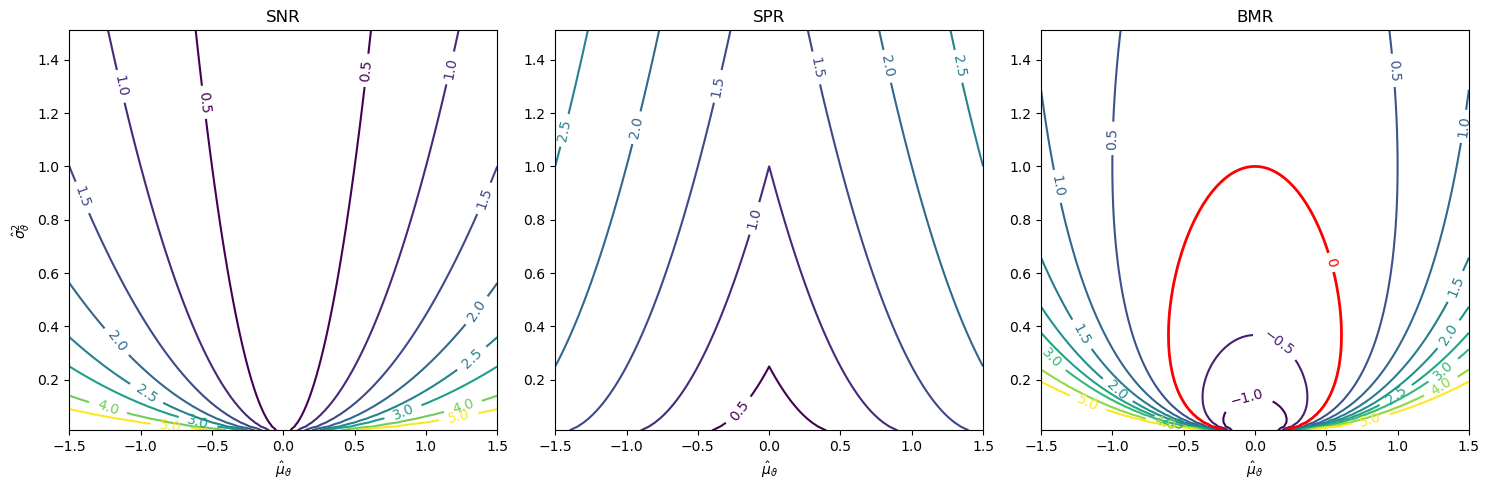

In [7]:
# plot results
fig, ax = plt.subplots(ncols=3, figsize=(15,5))
cf1 = ax[1].contour(μ_range, σ2_range, SNR_map', origin="lower", levels=[0.5, 1, 1.5, 2, 2.5, 3, 4, 5])
cf2 = ax[2].contour(μ_range, σ2_range, SPR_map', origin="lower", levels=[0.5, 1, 1.5, 2, 2.5, 3, 4, 5])
cf3 = ax[3].contour(μ_range, σ2_range, -BMR_map', origin="lower", levels=[-1.0, -0.5, 0.5, 1, 1.5, 2, 2.5, 3, 4, 5])
cf3r = ax[3].contour(μ_range, σ2_range, -BMR_map', levels=[0], origin="lower", colors="red", linewidths=2)
ax[1].set_title("SNR"), ax[2].set_title("SPR"), ax[3].set_title("BMR")
ax[1].set_ylabel(L"$\hat{\sigma}^2_\vartheta$")
ax[1].set_xlabel(L"$\hat{\mu}_\vartheta$")
ax[2].set_xlabel(L"$\hat{\mu}_\vartheta$")
ax[3].set_xlabel(L"$\hat{\mu}_\vartheta$")
ax[1].clabel(cf1, inline=true, fontsize=10)
ax[2].clabel(cf2, inline=true, fontsize=10)
ax[3].clabel(cf3, inline=true, fontsize=10)
ax[3].clabel(cf3r, inline=true, fontsize=10)
plt.tight_layout()

In [8]:
SNR_contours = contours(μ_range, σ2_range, SNR_map, [0.5, 1, 1.5, 2, 3, 5])
SPR_contours = contours(μ_range, σ2_range, SPR_map, [0.5, 1, 1.5, 2, 2.5, 3, 5])
BMR_contours = contours(μ_range, σ2_range, -BMR_map, [-0.5, 0.5, 1, 2, 3, 5])
BMR_contours_zero = contours(μ_range, σ2_range, -BMR_map, [0]);

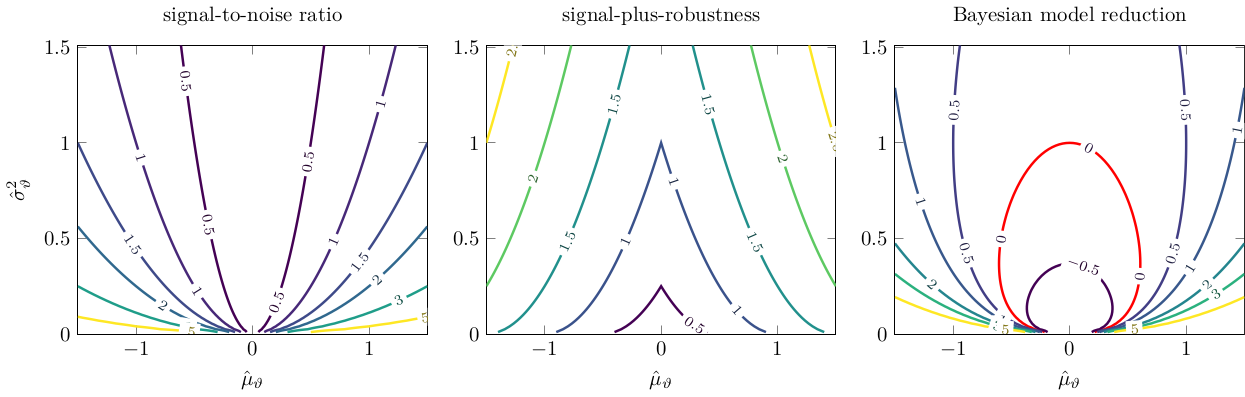

In [9]:
plt_comparison = @pgf GroupPlot(
    # group plot options
    {
        group_style = {
            group_size = "3 by 1",
            horizontal_sep = "1.0cm",
        },
        colormap_name = {
            viridis,
        },
        width = "7.5cm"
    },

    # axis 1 (SNR)
    {
        xlabel=raw"$\hat{\mu}_\vartheta$",
        ylabel=raw"$\hat{\sigma}^2_\vartheta$",
        view = (0, 90),
        title = "signal-to-noise ratio",
        ymin = 0, #first(σ2_range),
        ymax = last(σ2_range),
        xmin = first(μ_range),
        xmax = last(μ_range)
    },
    # plots for axis 1
    Plot(
        {
            contour_prepared,
            very_thick
        },
        Table(
            SNR_contours
        )
    ),

    # axis 2 (SPR)
    {
        xlabel=raw"$\hat{\mu}_\vartheta$",
        view = (0, 90),
        title = "signal-plus-robustness",
        ymin = 0, #first(σ2_range),
        ymax = last(σ2_range),
        xmin = first(μ_range),
        xmax = last(μ_range)
    },
    # plots for axis 2
    Plot(
        {
            contour_prepared,
            very_thick
        },
        Table(
            SPR_contours
        )
    ),

    # axis 3 (BMR)
    { 
        xlabel=raw"$\hat{\mu}_\vartheta$",
        view = (0, 90),
        title = "Bayesian model reduction",
        ymin = 0, #first(σ2_range),
        ymax = last(σ2_range),
        xmin = first(μ_range),
        xmax = last(μ_range),
    },
    # plots for axis 3
    Plot(
        {
            contour_prepared = {
                draw_color = {
                    red
                }
            },
            very_thick,
        },
        Table(
            BMR_contours_zero
        )
    ),
    Plot(
        {
            contour_prepared,
            very_thick
        },
        Table(
            BMR_contours
        )
    ),
)

In [10]:
pgfsave("exports/bmr_comparison_visualization.tikz", plt_comparison)
pgfsave("exports/bmr_comparison_visualization.pdf", plt_comparison)